In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

## units of the simulation 
- $L = \sqrt{D/k_{ab}^0}$
- $T = 1/k_{ab}^0$
- $E = 1/\beta$
## parameters of the simulation 
- $k_{bc}^0 = 1$ : equal to $k_{ab}^0$
- $k_{ac}^0 = 1$ : equal to $k_{ab}^0$
- $\epsilon_{ac}$ = 0.1
- $V$ = 1.

In [2]:
kbc = 1.
kac = 1.
Eac = 0.1
V0 = 1.

## Equation differential of the problem :
$$ 
\begin{cases}
& [\partial_x \rho_a]' = -\partial_x\rho_a \partial_x V - \rho_a \partial_x^2 V - \rho_b k_{ba} - \rho_c k_{ca} + \rho_a(k_{ac}+k_{ab})\\
& \rho_a' = \partial_x \rho_a \\
& [\partial_x \rho_b]' = -k_{ab} \rho_a - k_{cb} \rho_c + \rho_b(k_{bc}+k_{ba})\\
& \rho_b' = \partial_x \rho_b \\
& \rho_c = 1-\rho_a-\rho_b
\end{cases}
$$
Thus we write a system for $\rho_a$ and $\rho_b$ :
$$ 
\begin{cases}
& [\partial_x \rho_a]' = -\partial_x\rho_a \partial_x V - \rho_a \partial_x^2 V - \rho_b k_{ba} - (1-\rho_a-\rho_b) k_{ca} + \rho_a(k_{ac}+k_{ab})\\
& \rho_a' = \partial_x \rho_a \\
& [\partial_x \rho_b]' = -k_{ab} \rho_a - k_{cb} (1-\rho_a-\rho_b) + \rho_b(k_{bc}+k_{ba})\\
& \rho_b' = \partial_x \rho_b \\
\end{cases}
$$
with :
$$
\begin{cases}
&k_{ab} = e^V \hspace{1cm} k_{bc} = k_{bc}^0 \hspace{1cm} k_{ac} = k_{ac}^0e^V\\
&k_{ba} = 1 \hspace{1cm} k_{cb} = k_{bc}^0 \hspace{1cm} k_{ca} = k_{ac}^0 e^{-\epsilon_{ac}}
\end{cases}
$$
We define $\bar{\rho} = \{\partial_x\rho_a, \rho_a,\partial_x\rho_b,\rho_b\}$


And the associate matrix :
$$
P = 
\begin{bmatrix}
-\partial_xV & -\partial_x^2V+2k_{ac}^0e^V+e^V & 0 & -1 + k_{ac}^0e^V \\
1 & 0 & 0 & 0  \\
0 & -e^V +k_{bc}^0& 0 & 2*k_{bc}^0+1  \\
0 & 0 & 1 & 0 \\
\end{bmatrix}
$$
$$
B = \begin{bmatrix} &-k_{ac}^0 e^V\\ & 0\\ & -k_{bc}^0\\ & 0 \end{bmatrix}
$$
So that we get : 
$$
\bar{\rho}' = P \bar{\rho} + B
$$

In [7]:
def P(V,dV,ddV,x):
    return np.array([[-dV(x), -ddV(x) + (2*kac+1)*np.exp(V(x)),0,-1+kac*np.exp(V(x))],
                    [1,0,0,0],
                    [0,-np.exp(V(x))+kbc,0,2*kbc+1],
                    [0,0,1,0]])
def B(V,x):
    return np.array([-kac*np.exp(V(x)),0,-kbc,0])
#V = lambda x : 0.5*(1+np.tanh(x)) * V0
#dV = lambda x : 1/np.cosh(x)**2 * V0
#ddV = lambda x : -2/np.cosh(x)**2 * np.tanh(x) * V0
def V(x) :
    if x<0:
        return 0.
    else :
        return V0
dV = lambda x : 0
ddV = lambda x : 0
# We write the function f that takes two arguments : X (the position in space) and Y
# the value of the vector rho at X. The function simply returns the derivative of the
# vector rho at X
def f(X,Y):
    mat = P(V,dV,ddV,X)
    return np.dot(Y,mat) + B(V,X)

X0 = -10 # left most boundary condition
Xf = 10 # right most boundary at which we will perform the numerical resolution
n = 10000 # number of point use
h = (Xf-X0)/n # size of the step
print("step size : "+str(h))
def rk4(f,xn,yn):
    k1 = h * (f(xn, yn))
    k2 = h * (f((xn+h/2), (yn+k1/2)))
    k3 = h * (f((xn+h/2), (yn+k2/2)))
    k4 = h * (f((xn+h), (yn+k3)))
    k = (k1+2*k2+2*k3+k4)/6
    return yn + k

step size : 0.002


## Boundary conditions :
We only us left side boundary conditions (is it an issue ?). Far from the interface, where the potential is 0, the solution is the one given by the chemical steady state : 
$$
\begin{cases}
& \partial_x \rho_a^{-\infty} = 0 \\
& \rho_a^{-\infty} = (k_{ca}k_{ba} + k_{cb}k_{ba} + k_{bc}k_{ca})/S \\
& \partial_x\rho_b^{-\infty} = 0 \\
& \rho_b^{-\infty} = (k_{ca}k_{ab} + k_{ab}k_{cb} + k_{ac}k_{cb})/S \\
\end{cases}
$$
with $S = k_{ca}k_{ba} + k_{cb}k_{ba} + k_{bc}k_{ca} + k_{ca}k_{ab} + k_{ab}k_{cb} + k_{ac}k_{cb} + k_{ac}k_{bc} + k_{ba}k_{ac} + k_{ab}k_{bc}$

In [17]:
ra_no_norm = kac * np.exp(-Eac) * 1 + kbc*1 + kbc*kac*np.exp(-Eac)
rb_no_norm = kac*np.exp(-Eac)*np.exp(0)+np.exp(0)*kbc+kac*np.exp(0)*kbc
rc_no_norm = kac*np.exp(0)*kbc+1*kac*np.exp(0)+np.exp(0)*kbc
S = ra_no_norm+rb_no_norm#+rc_no_norm
ra_infty = ra_no_norm/S
rb_infty = rb_no_norm/S
rc_infty = rc_no_norm/S

rho_0 = np.array([0,ra_infty,0,rb_infty])

## Perform the numerical solution

In [10]:
rho_x = np.zeros((4,n),dtype=float)
x = X0
rho = rho_0
for step in range(n):
    rho = rk4(f,x,rho)
    x += h
    rho_x[:,step] = rho

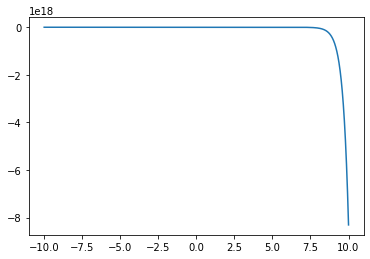

In [11]:
plt.plot(np.linspace(X0,Xf,n),rho_x[1,:])

In [18]:
rho_t = rho_0

In [19]:
for n in range(1000):
    rho_t = rk4(f,-1,rho_t)
print(rho_t-rho_0)

[-4.68345705 -7.61957036 -4.53002683 -7.36995295]


2.0611536366565986e-09